# UNET multi-class segmentation

Zander"s notebook from [collab](https://colab.research.google.com/drive/1Pgc69SbOJqItxYV8d4sFgVlW7xUz0dEU?usp=sharing#scrollTo=3597294c-8f36-4c61-990e-0586fb8345d1)


In [3]:
from collections.abc import Callable, Iterable
from pathlib import Path

import matplotlib.pyplot as plt
import rasterio as rio
import rioxarray as rxr
import segmentation_models_pytorch as smp
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.metrics import jaccard_score
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.samplers import RandomGeoSampler, Units
from tqdm.auto import tqdm

In [7]:
multiclass_segmentation_dir = Path(
    "/home/taheera.ahmed/code/test-multiclass-segmentation"
)

In [9]:
root = multiclass_segmentation_dir / "dset-s2-grunnkart"
if not root.exists():
    raise FileNotFoundError(f"The directory {root} does not exist.")

train_imgs = list((root / "tra_scene").glob("*.tif"))
train_masks = list((root / "tra_truth").glob("*.tif"))

val_imgs = list((root / "val_scene").glob("*.tif"))
val_masks = list((root / "val_truth").glob("*.tif"))

# As the images and corresponding masks are matched by name, we will sort both lists to
# keep them synchronized.
train_imgs.sort()
train_masks.sort()
val_imgs.sort()
val_masks.sort()

## Visualize a as single image


In [10]:
idx = 2
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

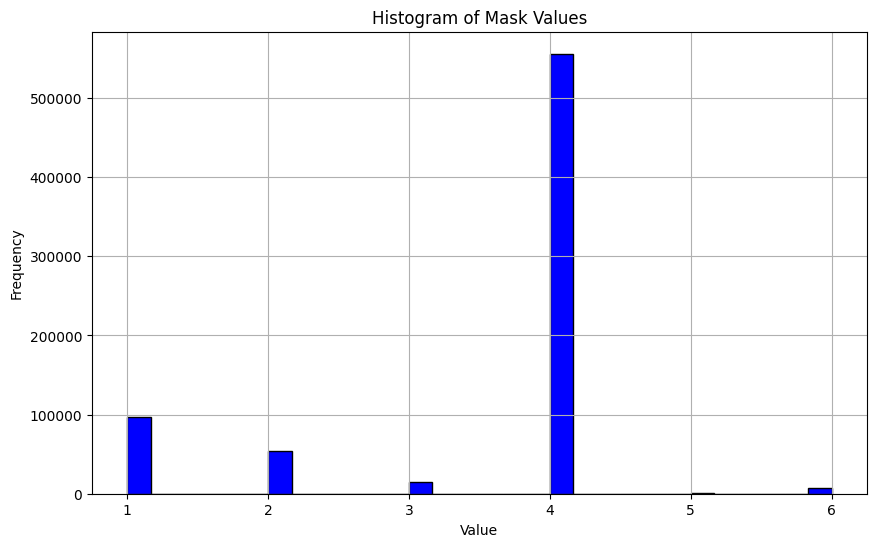

In [11]:
# Extract the data
mask_data = mask.values[0]  # Assuming mask has only one band

# Flatten the array to 1D for histogram
mask_data_flattened = mask_data.flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(mask_data_flattened, bins=30, color="blue", edgecolor="black")
plt.title("Histogram of Mask Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

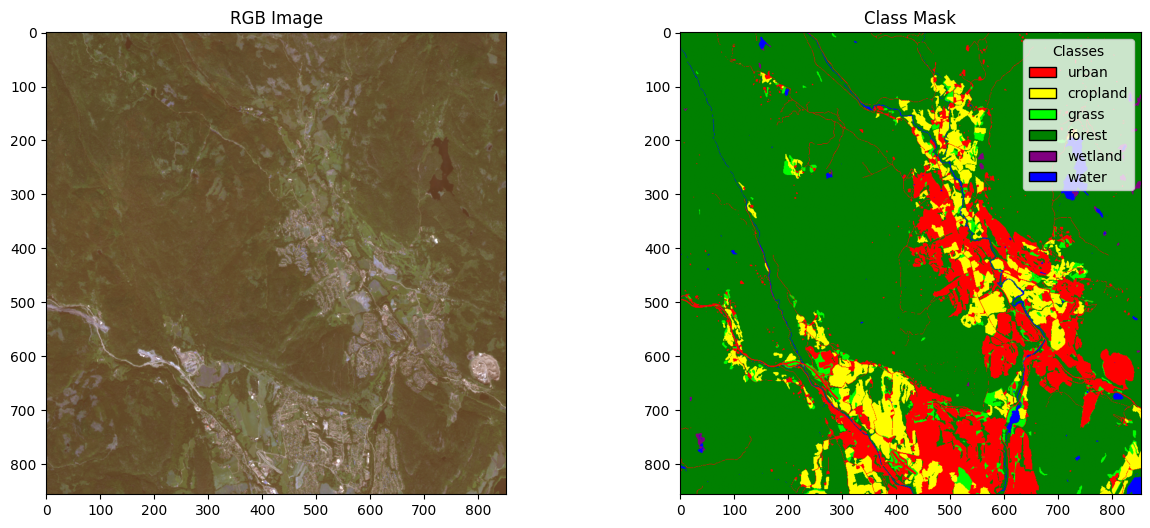

In [12]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# Define the class labels and corresponding colors
class_labels = ["urban", "cropland", "grass", "forest", "wetland", "water"]
class_colors = ["red", "yellow", "lime", "green", "purple", "blue"]

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0)) / 2000
axs[0].imshow(rgb.clip(min=0, max=1))
axs[0].set_title("RGB Image")

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

# Add the legend to the second subplot
axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

## Test out converting to torchgeo objects


In [13]:
train_ds = RasterDataset(
    paths=(root / "tra_scene").as_posix(), crs="epsg:32633", res=10
)

In [14]:
sampler = RandomGeoSampler(train_ds, size=(256, 256), length=20)

In [15]:
# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample["image"].shape)

dict_keys(['crs', 'bounds', 'image'])
torch.Size([6, 256, 256])


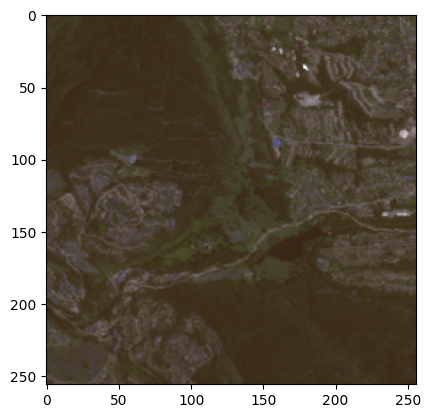

In [16]:
arr = torch.clamp(sample["image"] / 10000, min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [2, 1, 0]]

plt.imshow(rgb * 3)

In [17]:
import logging

# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

## Creating the image sampler, training dataset, and data loader


In [19]:
def scale(item: dict):
    item["image"] = item["image"] / 10000
    return item

In [20]:
train_imgs = RasterDataset(
    paths=(root / "tra_scene").as_posix(), crs="epsg:32633", res=10, transforms=scale
)
train_msks = RasterDataset(
    paths=(root / "tra_truth").as_posix(), crs="epsg:32633", res=10
)

# IMPORTANT
train_msks.is_image = False

In [21]:
sampler = RandomGeoSampler(train_imgs, size=256, length=30, units=Units.PIXELS)

In [22]:
# let"s get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

dict_keys(['crs', 'bounds', 'image']) dict_keys(['crs', 'bounds', 'mask'])


In [24]:
# let"s assert the patches cover the same region...
print(img_sample["bounds"])
print(msk_sample["bounds"])

if img_sample["bounds"] != msk_sample["bounds"]:
    raise AssertionError("The image and mask do not cover the same region.")

BoundingBox(minx=244720.0, maxx=247280.0, miny=6640090.0, maxy=6642650.0, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=244720.0, maxx=247280.0, miny=6640090.0, maxy=6642650.0, mint=0.0, maxt=9.223372036854776e+18)


In [25]:
train_dset = train_imgs & train_msks

In [26]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bounds', 'image', 'mask'])

In [27]:
len(train_imgs)

4

In [28]:
dataloader = DataLoader(
    train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples
)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bounds', 'image', 'mask'])

In [29]:
batch["image"].shape

torch.Size([8, 6, 256, 256])

In [31]:
def plot_imgs(
    images: Iterable, axs: Iterable, chnls: list[int] = [2, 1, 0], bright: float = 3.0
):
    for img, ax in zip(images, axs, strict=False):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis("off")


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs, strict=False):
        ax.imshow(
            mask.squeeze().numpy(),
            cmap=ListedColormap(
                ["black", "red", "yellow", "lime", "green", "purple", "blue"]
            ),
            vmin=0,
            vmax=6,
            interpolation="nearest",
        )
        ax.axis("off")


def plot_batch(
    batch: dict,
    bright: float = 3.0,
    cols: int = 4,
    width: int = 5,
    chnls: list[int] = [2, 1, 0],
):
    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ("image" in batch) and ("mask" in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n // cols + (1 if n % cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * width))

    if ("image" in batch) and ("mask" in batch):
        # plot the images on the even axis
        plot_imgs(
            images=map(lambda x: x["image"], samples),
            axs=axs.reshape(-1)[::2],
            chnls=chnls,
            bright=bright,
        )  # type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x["mask"], samples), axs=axs.reshape(-1)[1::2])  # type: ignore

    else:
        if "image" in batch:
            plot_imgs(
                images=map(lambda x: x["image"], samples),
                axs=axs.reshape(-1),
                chnls=chnls,
                bright=bright,
            )  # type: ignore

        elif "mask" in batch:
            plot_msks(masks=map(lambda x: x["mask"], samples), axs=axs.reshape(-1))  # type: ignore

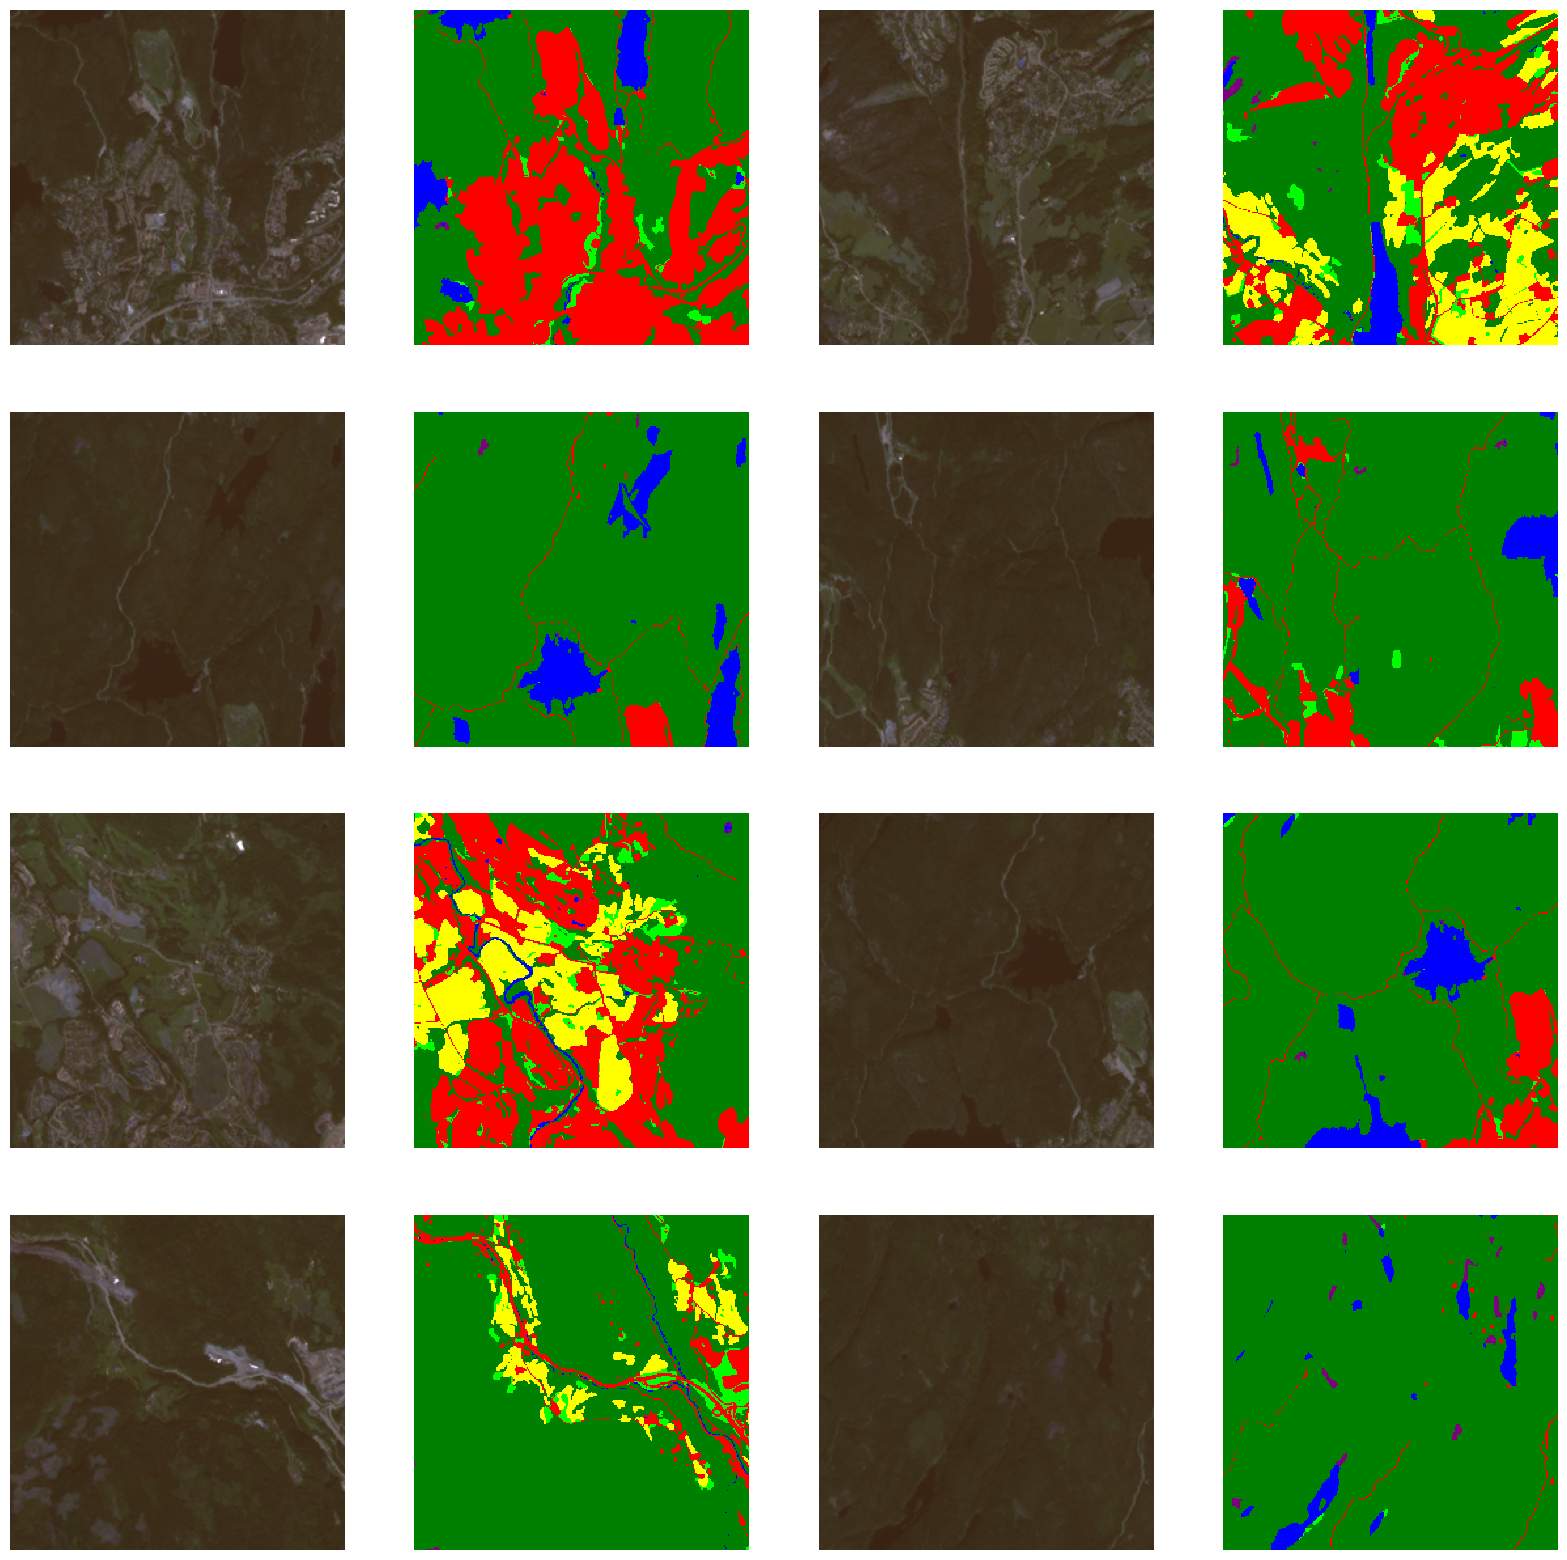

In [32]:
plot_batch(batch)

## Image normalization


In [33]:
def calc_statistics(dset: RasterDataset):
    """
    Calculate the statistics (mean and std) for the entire dataset
    Warning: This is an approximation. The correct value should take into account the
    mean for the whole dataset for computing individual stds.
    For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
    """

    # To avoid loading the entire dataset in memory, we will loop through each img
    # The filenames will be retrieved from the dataset"s rtree index
    files = [
        item.object for item in dset.index.intersection(dset.index.bounds, objects=True)
    ]

    # Reseting statistics
    accum_mean = 0
    accum_std = 0

    for file in files:
        img = rio.open(file).read() / 10000  # type: ignore
        accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
        accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

    # at the end, we shall have 2 vectors with lenght n=chnls
    # we will average them considering the number of images
    return accum_mean / len(files), accum_std / len(files)


mean, std = calc_statistics(train_imgs)
print(mean, std)

[0.04858754 0.07162346 0.08922228 0.1774709  0.09676766 0.42039867] [0.02395906 0.01916849 0.01539212 0.09007944 0.05573626 0.28926683]


In [34]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: list[float], stdev: list[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):
        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the "image" key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

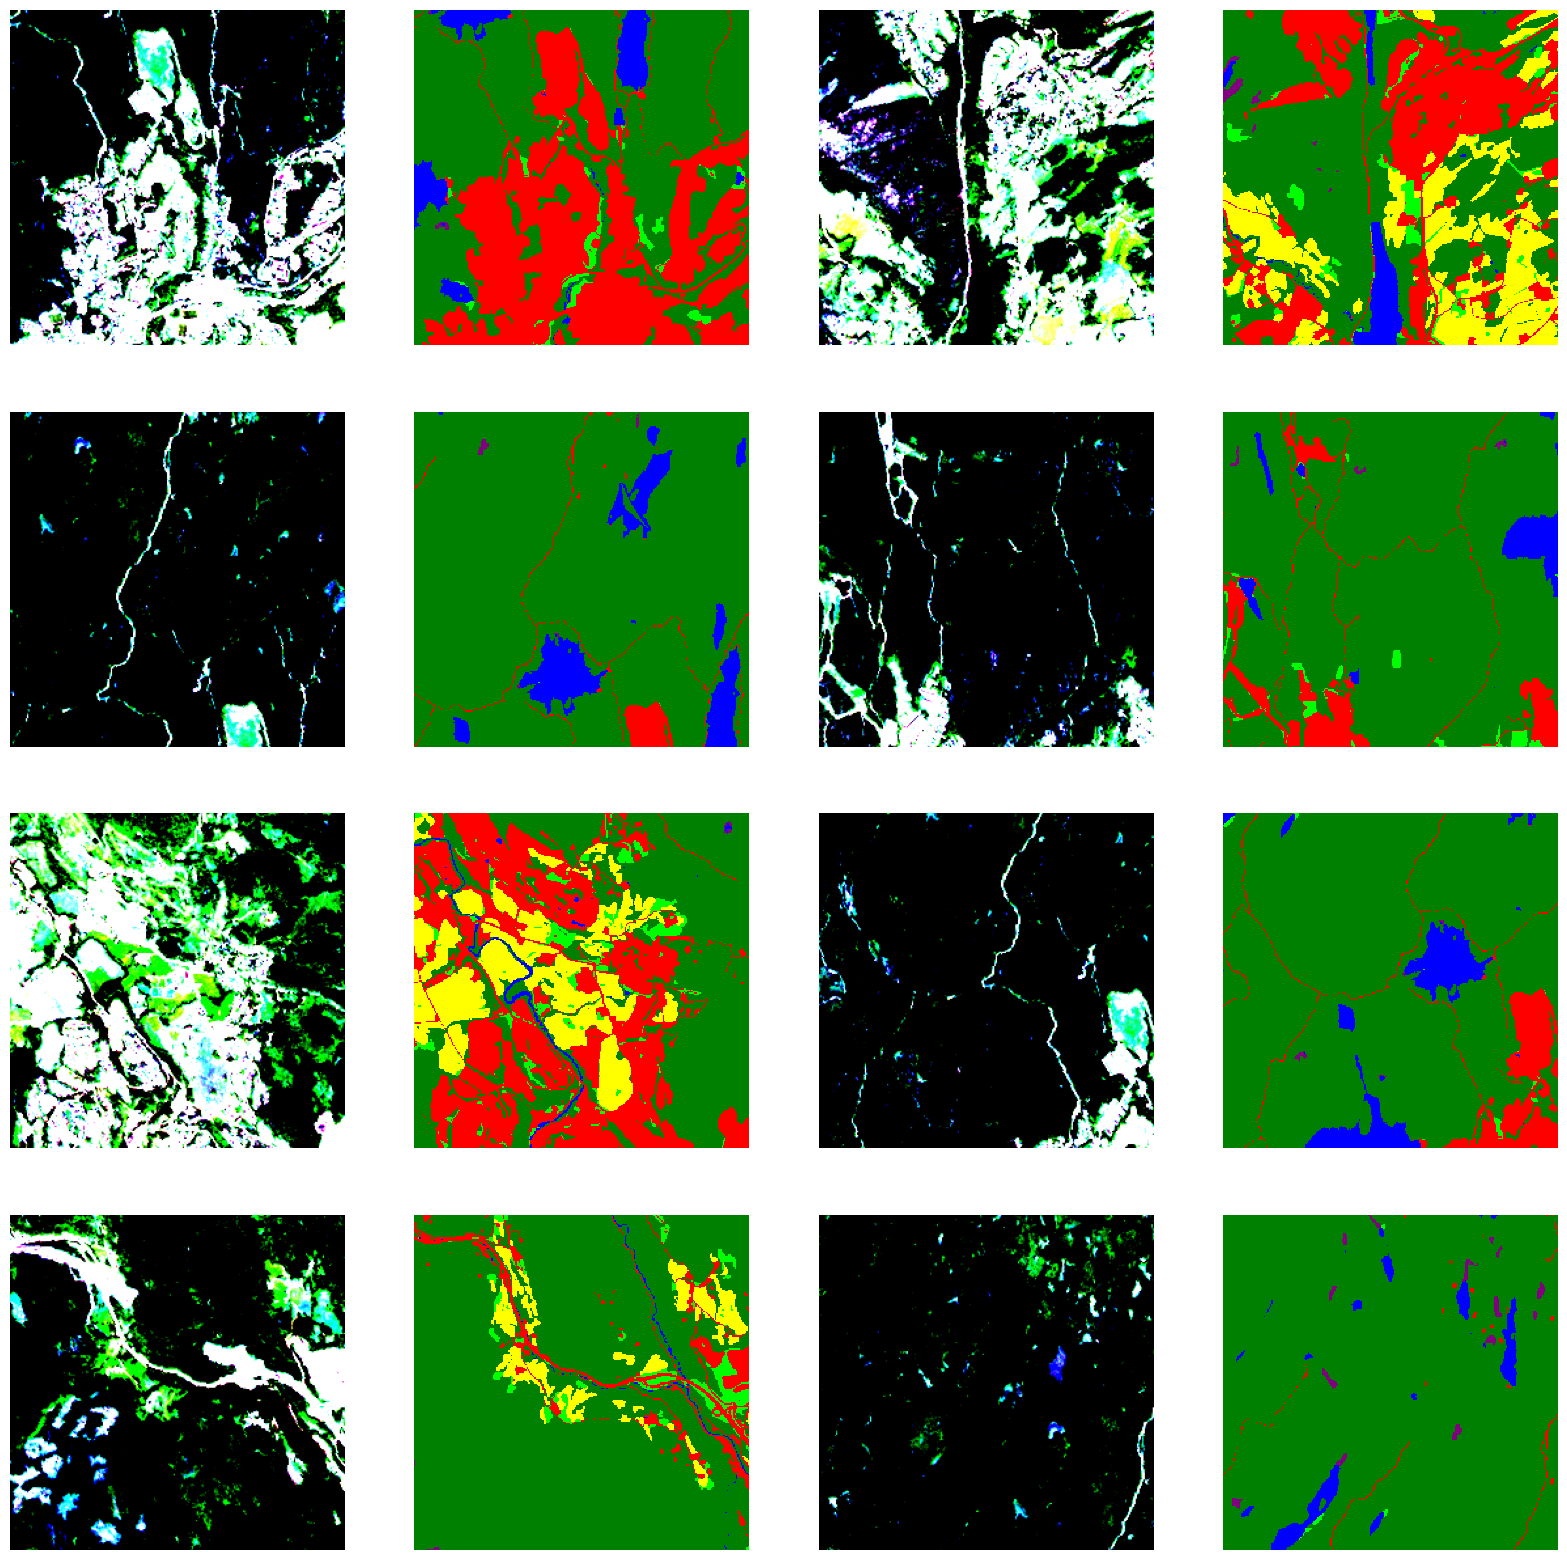

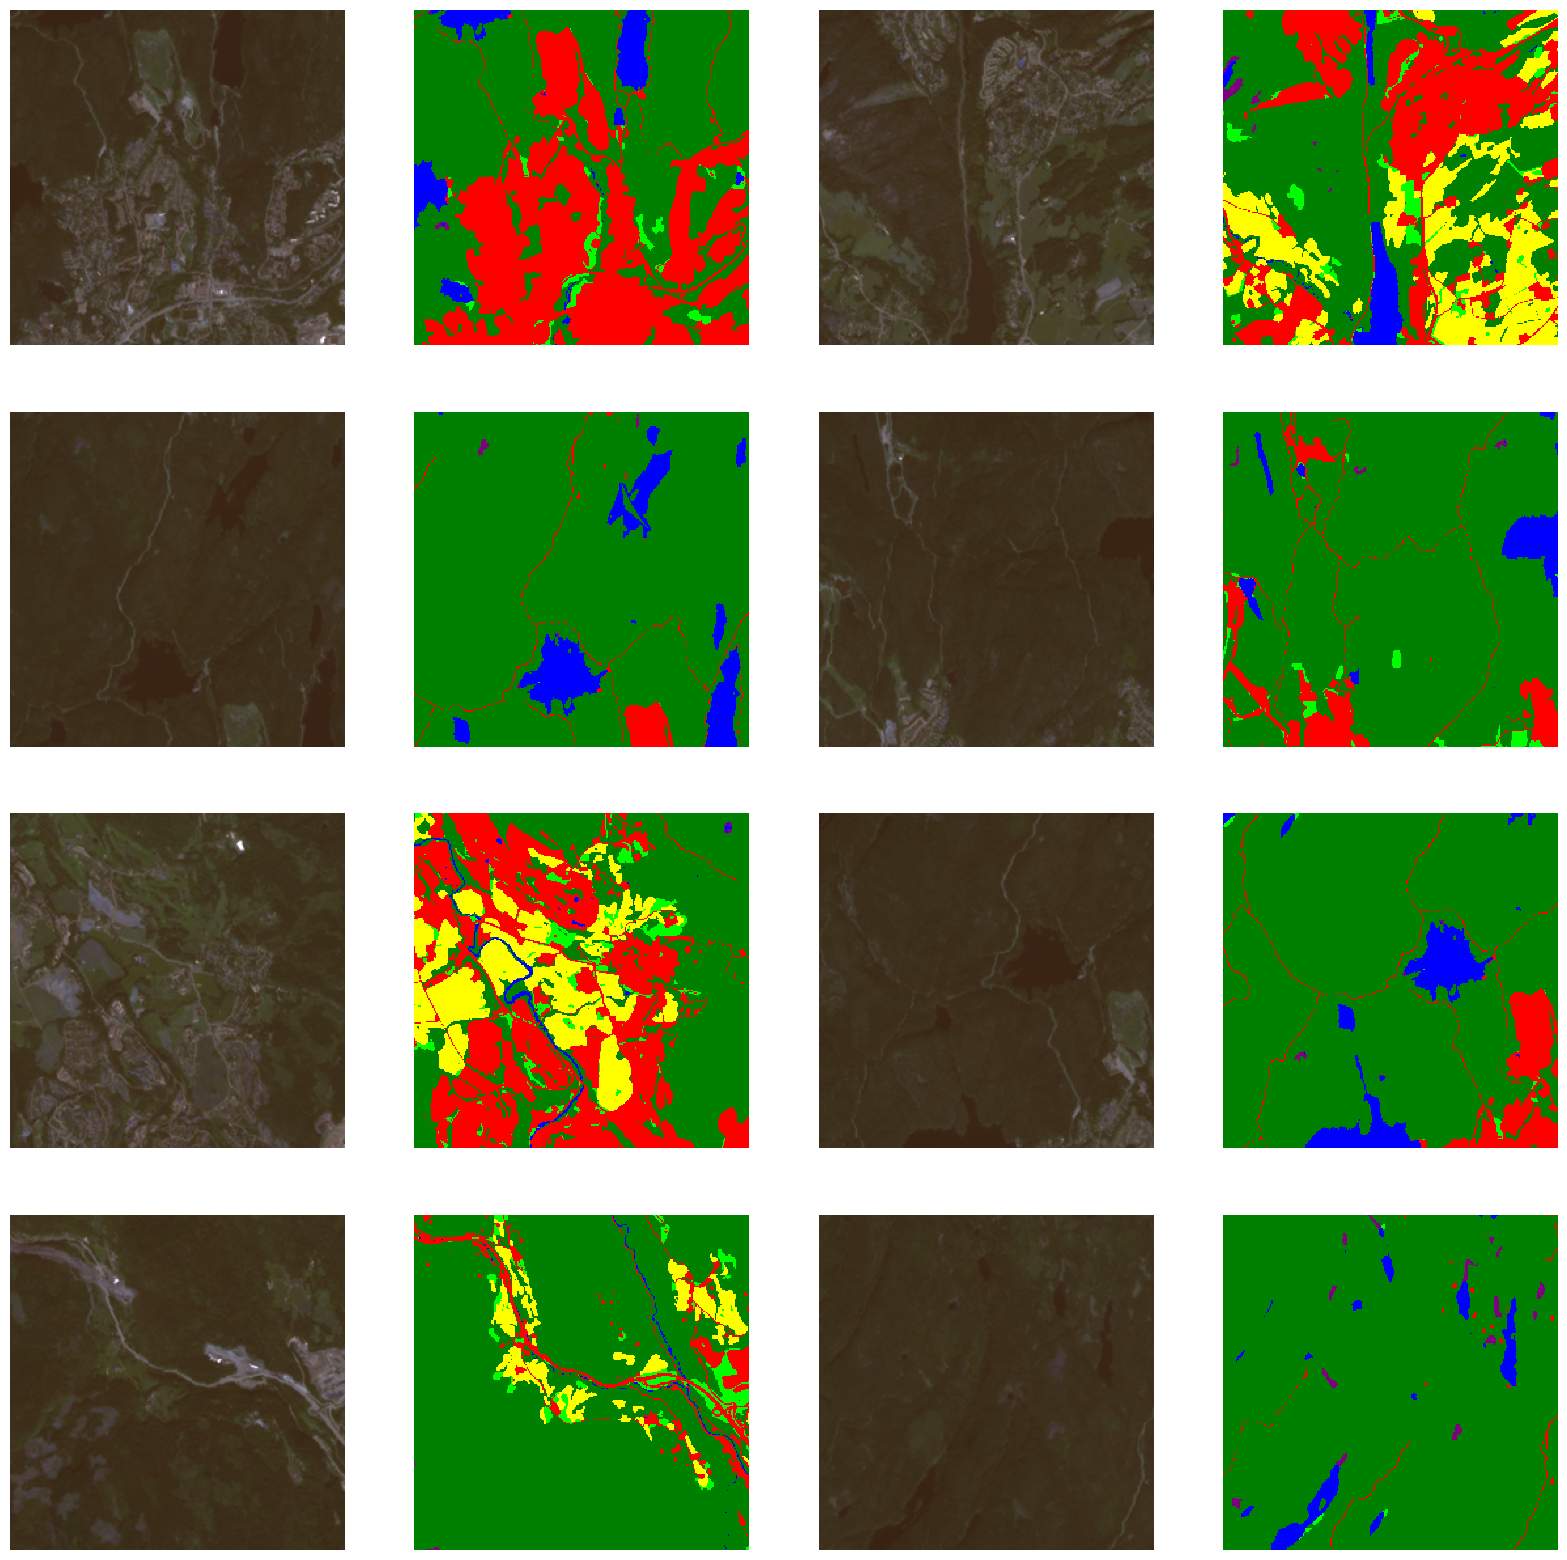

In [35]:
normalize = MyNormalize(mean=mean, stdev=std)
norm_batch = normalize(batch)
plot_batch(norm_batch)

batch = normalize.revert(norm_batch)
plot_batch(batch)

In [36]:
tfms = torch.nn.Sequential(normalize)

new_transformed_batch = tfms(batch)
print(batch["image"].shape, batch["mask"].shape)

torch.Size([8, 6, 256, 256]) torch.Size([8, 1, 256, 256])


## Create UNET model and move to GPU


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=6,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=7,  # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [40]:
pred = model(torch.randn(3, 6, 256, 256, device=device))
pred.shape

torch.Size([3, 7, 256, 256])

## Define training loop


In [41]:
def train_loop(
    epochs: int,
    train_dl: DataLoader,
    val_dl: DataLoader | None,
    model: torch.nn.Module,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    acc_fns: list | None = None,
    batch_tfms: Callable | None = None,
):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        accum_train_loss = 0
        for batch in train_dl:
            if batch_tfms is not None:
                batch = batch_tfms(batch)

            X = batch["image"].to(device)
            y = batch["mask"].type(torch.long).to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the accum loss
            accum_train_loss += float(loss) / len(train_dl)

        train_losses.append(accum_train_loss)

        model.eval()
        accum_val_loss = 0
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.0] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:
                    if batch_tfms is not None:
                        batch = batch_tfms(batch)

                    X = batch["image"].type(torch.float32).to(device)
                    y = batch["mask"].type(torch.long).to(device)

                    pred = model(X)
                    val_loss = loss_fn(pred, y)
                    accum_val_loss += float(val_loss) / len(val_dl)

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y) / len(val_dl))

            val_losses.append(accum_val_loss)
            val_accuracies.append(acc)

            # Print the metrics at the end of the epoch
            print(
                f"Epoch {epoch}: Train Loss={accum_train_loss:.5f} - Val Loss={accum_val_loss:.5f} - Accs={[round(a, 3) for a in acc]}"
            )
        else:
            val_losses.append(None)
            val_accuracies.append(None)
            print(f"Epoch {epoch}: Train Loss={accum_train_loss:.5f}")

    # Plotting the metrics
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    if val_dl is not None:
        plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    if val_dl is not None and acc_fns is not None:
        for i, acc_fn in enumerate(acc_fns):
            plt.plot(
                [acc[i] for acc in val_accuracies if acc is not None],
                label=f"Val Acc {i}",
            )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Validation Accuracy")

    plt.tight_layout()
    plt.show()


# Example usage
# train_loop(epochs, train_dl, val_dl, model, loss_fn, optimizer, acc_fns=[oa, iou], batch_tfms=None)

In [42]:
def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc


def iou(pred, y, num_classes=7):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    ious = []
    for class_id in range(num_classes):
        iou = jaccard_score(
            flat_y.reshape(-1),
            flat_pred.reshape(-1),
            labels=[class_id],
            average="macro",
            zero_division=1.0,
        )
        ious.append(iou)
    return sum(ious) / num_classes


def loss(p, t):
    return torch.nn.functional.cross_entropy(p, t.squeeze())

In [43]:
train_imgs = RasterDataset(
    paths=(root / "tra_scene").as_posix(), crs="epsg:32633", res=10, transforms=scale
)
train_msks = RasterDataset(
    paths=(root / "tra_truth").as_posix(), crs="epsg:32633", res=10
)

valid_imgs = RasterDataset(
    paths=(root / "val_scene").as_posix(), crs="epsg:32633", res=10, transforms=scale
)
valid_msks = RasterDataset(
    paths=(root / "val_truth").as_posix(), crs="epsg:32633", res=10
)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=256, length=32, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=256, length=16, units=Units.PIXELS)


train_dataloader = DataLoader(
    train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples
)
valid_dataloader = DataLoader(
    valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples
)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bounds', 'image', 'mask']),
 dict_keys(['crs', 'bounds', 'image', 'mask']))

 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

Epoch 0: Train Loss=1.83589 - Val Loss=8.44208 - Accs=[0.484, 0.12]


 20%|██        | 2/10 [00:05<00:19,  2.46s/it]

Epoch 1: Train Loss=1.29143 - Val Loss=5.28288 - Accs=[0.569, 0.176]


 30%|███       | 3/10 [00:06<00:15,  2.20s/it]

Epoch 2: Train Loss=0.94017 - Val Loss=1.61512 - Accs=[0.671, 0.223]


 40%|████      | 4/10 [00:08<00:12,  2.02s/it]

Epoch 3: Train Loss=0.84297 - Val Loss=1.42774 - Accs=[0.719, 0.217]


 50%|█████     | 5/10 [00:10<00:09,  1.91s/it]

Epoch 4: Train Loss=0.75249 - Val Loss=1.83174 - Accs=[0.704, 0.237]


 60%|██████    | 6/10 [00:13<00:08,  2.16s/it]

Epoch 5: Train Loss=0.96229 - Val Loss=0.65420 - Accs=[0.864, 0.361]


 70%|███████   | 7/10 [00:15<00:06,  2.12s/it]

Epoch 6: Train Loss=0.72276 - Val Loss=0.57872 - Accs=[0.873, 0.416]


 80%|████████  | 8/10 [00:17<00:04,  2.06s/it]

Epoch 7: Train Loss=0.56912 - Val Loss=1.05154 - Accs=[0.875, 0.432]


 90%|█████████ | 9/10 [00:18<00:01,  2.00s/it]

Epoch 8: Train Loss=0.52207 - Val Loss=0.56853 - Accs=[0.871, 0.487]


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

Epoch 9: Train Loss=0.67671 - Val Loss=0.40536 - Accs=[0.895, 0.537]


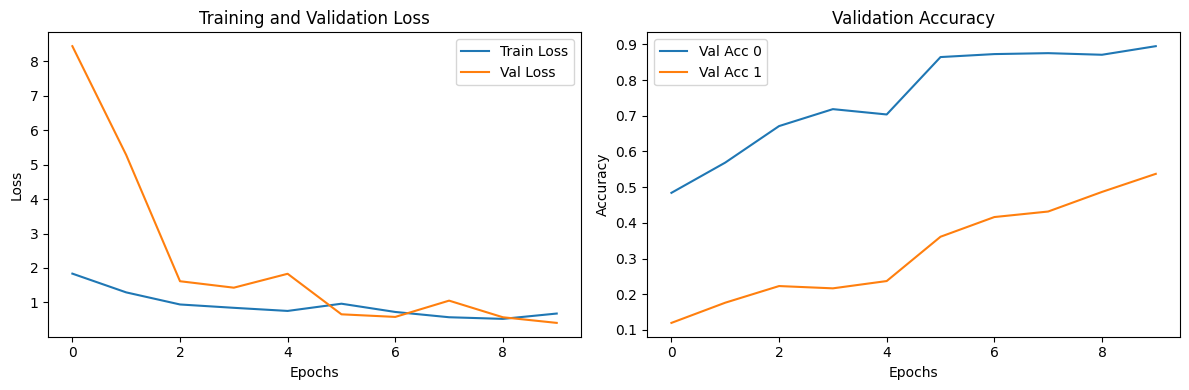

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
train_loop(
    10,
    train_dataloader,
    valid_dataloader,
    model,
    loss,
    optimizer,
    acc_fns=[oa, iou],
    batch_tfms=tfms,
)

### Make inference on an image and plot predictions


In [45]:
batch_pred = next(iter(valid_dataloader))
inB = tfms(batch_pred)["image"].to(device)
out = model(inB)
out.shape

torch.Size([8, 7, 256, 256])

In [47]:
batch_pred = normalize.revert(batch_pred)
# plot_batch(batch_pred)
out.shape

torch.Size([8, 7, 256, 256])

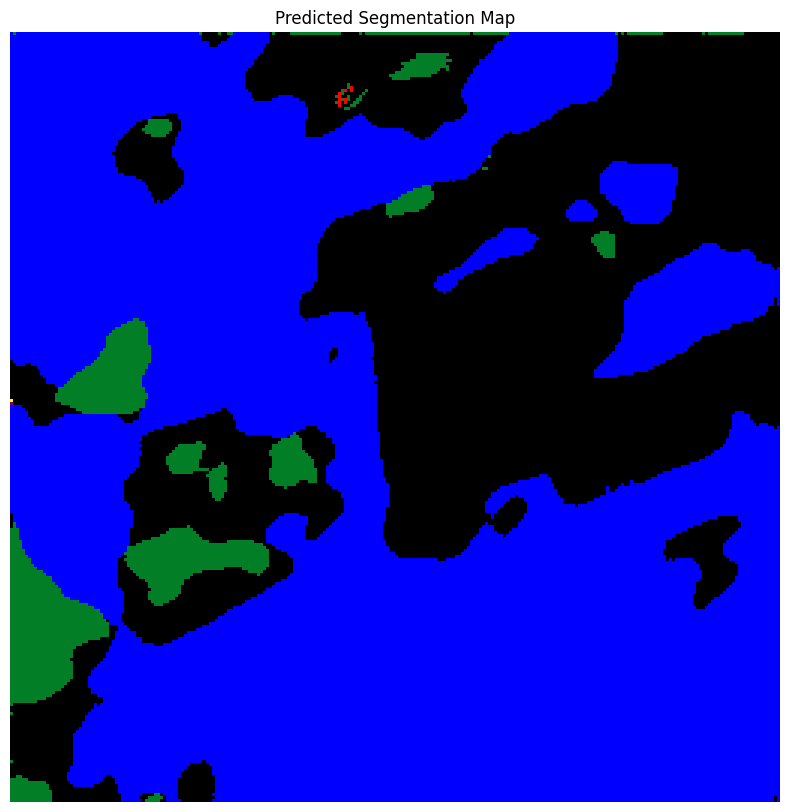

In [48]:
# Get the predicted class for each pixel
pred_classes = out.argmax(dim=1)  # Shape will be [batch_size, height, width]

# Move the predictions to the CPU if they are on a GPU
pred_classes = pred_classes.cpu()

# Select one image from the batch to visualize
idx = 4  # Index of the image in the batch to visualize
pred_image = pred_classes[idx].numpy()  # Convert to NumPy array for visualization

# Plot the predicted image
plt.figure(figsize=(10, 10))
plt.imshow(
    pred_image,
    cmap=ListedColormap(
        ["black", "red", "yellow", "green", "#027e27", "purple", "blue"]
    ),
)
plt.title("Predicted Segmentation Map")
plt.axis("off")
plt.show()

In [49]:
def plot_imgs(
    images: Iterable, axs: Iterable, chnls: list[int] = [2, 1, 0], bright: float = 3.0
):
    for img, ax in zip(images, axs, strict=False):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis("off")


def plot_msks(masks: Iterable, axs: Iterable):
    colormap = ListedColormap(
        ["black", "red", "yellow", "green", "#027e27", "purple", "blue"]
    )
    for mask, ax in zip(masks, axs, strict=False):
        ax.imshow(
            mask.squeeze().numpy(),
            cmap=colormap,
            vmin=0,
            vmax=6,
            interpolation="nearest",
        )
        ax.axis("off")


def plot_preds(predictions: Iterable, axs: Iterable):
    colormap = ListedColormap(
        ["black", "red", "yellow", "green", "#027e27", "purple", "blue"]
    )
    for pred, ax in zip(predictions, axs, strict=False):
        ax.imshow(
            pred.squeeze(), cmap=colormap, vmin=0, vmax=6, interpolation="nearest"
        )
        ax.axis("off")


def plot_batch_val(
    batch: dict,
    predictions: torch.Tensor,
    bright: float = 3.0,
    cols: int = 3,
    width: int = 5,
    chnls: list[int] = [2, 1, 0],
):
    # Get the samples and the number of items in the batch
    samples = batch["image"]

    # calculate the number of rows in the grid
    rows = len(samples)

    # create a grid
    fig, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * width))

    if rows == 1:
        axs = [axs]  # Ensure axs is iterable even if there's only one row

    # plot the images in the first column
    plot_imgs(images=samples, axs=[ax[0] for ax in axs], chnls=chnls, bright=bright)

    # plot the masks in the second column
    plot_msks(masks=batch["mask"], axs=[ax[1] for ax in axs])

    # plot the predictions in the third column
    pred_classes = predictions.argmax(dim=1).cpu().numpy()
    plot_preds(predictions=pred_classes, axs=[ax[2] for ax in axs])

    plt.tight_layout()
    plt.show()

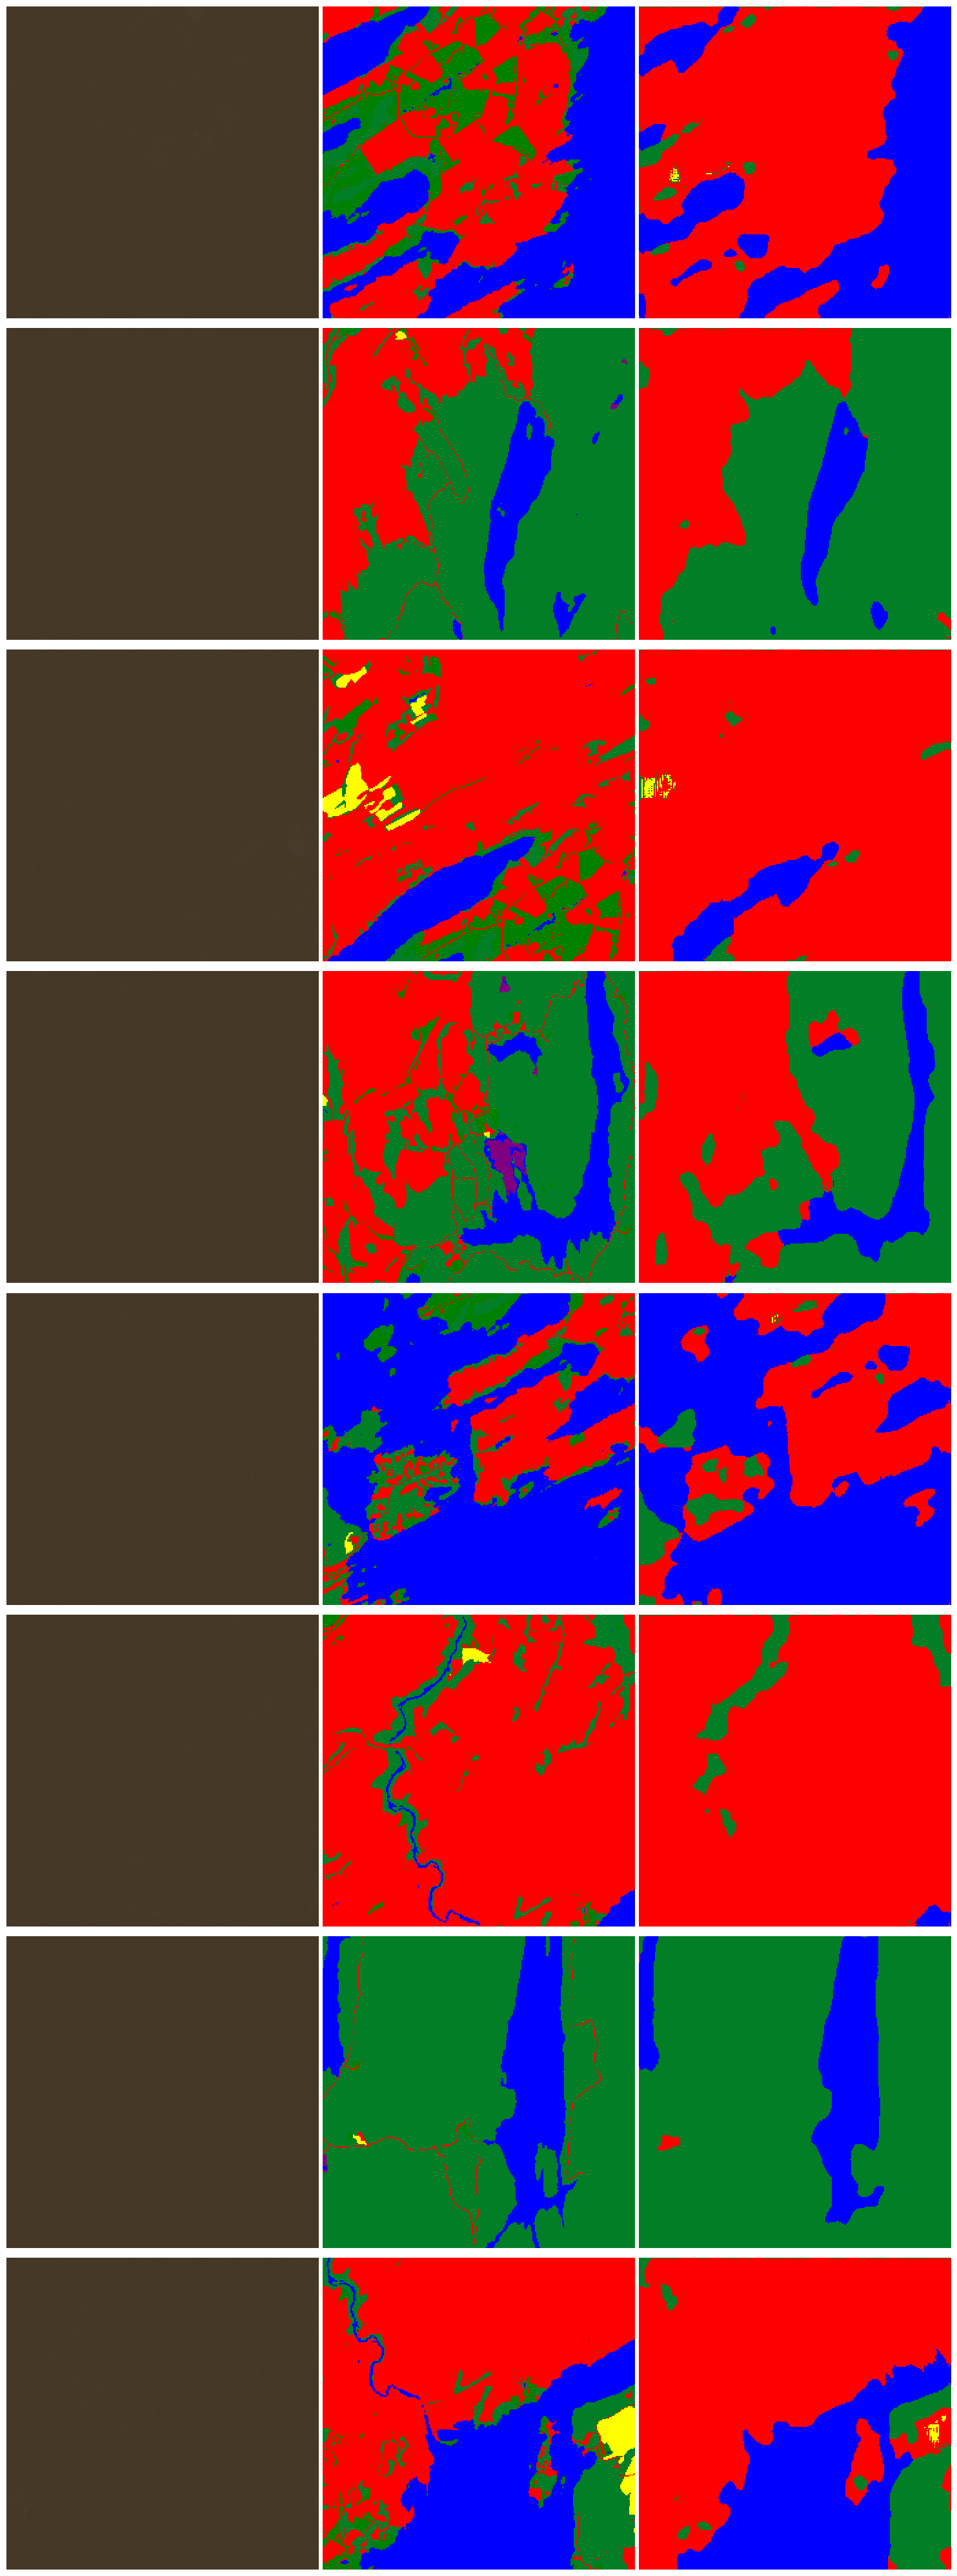

In [50]:
plot_batch_val(
    batch=batch_pred, predictions=out, bright=3.0, cols=3, width=5, chnls=[2, 1, 0]
)